In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import xarray as xr
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.data import Data, Dataset
from Trainer_loocv import Trainer
from wind_utils import get_distance, draw_graph, nearest_neighbors_graph, plot_heatmap, dataset_generation
from GCN_Regression import GCN_RegressionModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import pearsonr
df = pd.read_csv('data/final_data_mar.csv.gz')
df['time'] = pd.to_datetime(df['time'])
df.head()

,time,station_id,longitude,latitude,PM25_Concentration,weather,temperature,humidity,wind_speed,wind_direction,filled
0,2014-05-01 00:00:00,1002,116.20531,40.00395,89.0,0.0,20.0,56.0,7.92,13.0,False
1,2014-05-01 01:00:00,1002,116.20531,40.00395,85.0,0.0,18.0,64.0,7.56,13.0,False
2,2014-05-01 02:00:00,1002,116.20531,40.00395,88.0,0.0,18.0,70.0,5.76,13.0,False
3,2014-05-01 03:00:00,1002,116.20531,40.00395,100.0,0.0,17.0,74.0,6.12,13.0,False
4,2014-05-01 04:00:00,1002,116.20531,40.00395,109.0,0.0,17.0,75.0,4.68,1.0,False


In [3]:
df = df.rename(columns = {'wind_speed':'WS', 'wind_direction':'WD'})
df.head()

,time,station_id,longitude,latitude,PM25_Concentration,weather,temperature,humidity,WS,WD,filled
0,2014-05-01 00:00:00,1002,116.20531,40.00395,89.0,0.0,20.0,56.0,7.92,13.0,False
1,2014-05-01 01:00:00,1002,116.20531,40.00395,85.0,0.0,18.0,64.0,7.56,13.0,False
2,2014-05-01 02:00:00,1002,116.20531,40.00395,88.0,0.0,18.0,70.0,5.76,13.0,False
3,2014-05-01 03:00:00,1002,116.20531,40.00395,100.0,0.0,17.0,74.0,6.12,13.0,False
4,2014-05-01 04:00:00,1002,116.20531,40.00395,109.0,0.0,17.0,75.0,4.68,1.0,False


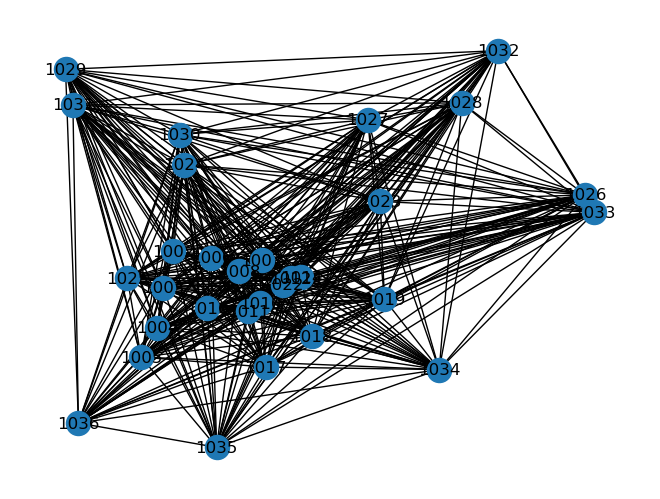

In [4]:
grouped = df.groupby('station_id')['PM25_Concentration'].mean()

# Create a dictionary where the keys are the station_ids and the values are the mean PM2.5 concentrations
station_pm25 = grouped.to_dict()

# Calculate the Pearson correlation between all pairs of stations
correlations = {}
station_ids = df['station_id'].unique()

for i in range(len(station_ids)):
    for j in range(i+1, len(station_ids)):
        station1 = df[df['station_id'] == station_ids[i]]['PM25_Concentration']
        station2 = df[df['station_id'] == station_ids[j]]['PM25_Concentration']
        correlation, _ = pearsonr(station1, station2)
        correlations[(station_ids[i], station_ids[j])] = correlation

# Create a graph where the nodes are the station_ids and the edges are the Pearson correlations
G = nx.Graph()

# Add nodes to the graph
for station_id in station_ids:
    G.add_node(station_id, pos=(df[df['station_id'] == station_id]['longitude'].values[0],
                               df[df['station_id'] == station_id]['latitude'].values[0]))

# Add edges to the graph
for pair, correlation in correlations.items():
    G.add_edge(*pair, weight=correlation)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True)


In [5]:
df_ = df[df["time"] == "2014-05-01 00:00:00"]
# choose the columns to be used for the prediction]
df__ = df_["PM25_Concentration"]
df_ = df_[[ "longitude", "latitude", "temperature", "weather", "humidity", "WS", "WD"]]
df_.head()

,longitude,latitude,temperature,weather,humidity,WS,WD
0,116.205310,40.003950,20.0,0.0,56.0,7.92,13.0
8760,116.184239,39.914409,20.0,0.0,56.0,7.92,13.0
17520,116.171150,39.815128,20.0,0.0,56.0,7.92,13.0
26280,116.136045,39.742767,19.0,0.0,61.0,11.16,13.0
35040,116.287451,39.987313,20.0,0.0,56.0,7.92,13.0


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 100)
        self.linear1 = nn.Linear(100, 100)
        self.linear2 = nn.Linear(100, 1)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        x= self.linear1(x)
        x = nn.ReLU()(x)
        x = self.linear2(x)
        x = nn.ReLU()(x)
        return x



In [7]:
def train(self, lr):
        """
        Trains the model.

        """
        self.model.to(self.device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        for epoch in range(self.epochs):
            optimizer.zero_grad()
            out = self.model(self.data.x.to(self.device), self.data.edge_index.to(self.device))
            loss = criterion(out[self.data.train_mask].squeeze(), self.data.y[self.data.train_mask].squeeze())
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                self.model.eval()
                with torch.no_grad():
                    out = self.model(self.data.x.to(self.device), self.data.edge_index.to(self.device))  # Predicted PM values
                    train_rmse = torch.sqrt(torch.mean((out[self.data.train_mask].squeeze() - self.data.y[self.data.train_mask].squeeze())**2))
                    test_rmse = torch.sqrt(torch.mean((out[self.data.test_mask].squeeze() - self.data.y[self.data.test_mask].squeeze())**2))
#                     print(f"Epoch {epoch}: Train RMSE {train_rmse:.4f}, Test RMSE {test_rmse:.4f}")
                self.model.train()

In [53]:
import statsmodels.api as sm
# for i in range(1,48):

pm = df[df["station_id"] == 1002]["PM25_Concentration"]
ws = df[df["station_id"] == 1002]["WS"]
ws = ws.shift(periods=-i)
ws = ws.iloc[:-i]
pm = pm.iloc[:-i]
#calculate cross correlation
correlation = sm.tsa.stattools.ccf(pm, ws, adjusted=False)
print(i, "Correlation coefficient:", correlation)


47 Correlation coefficient: [-3.70590720e-02 -3.60883455e-02 -3.37948143e-02 ...  7.48044341e-05
  2.94243125e-05 -2.96210145e-06]


In [55]:
# return max correlation and its indeces
max_correlation = max(correlation)
max_correlation_index = np.argmax(correlation)
print("Max correlation:", max_correlation)
print("Max correlation index:", max_correlation_index)

Max correlation: 0.11326005607166803
Max correlation index: 1601


In [56]:
for i in range(48):
    print(correlation[i])

-0.03705907197575917
-0.03608834547547286
-0.03379481430881813
-0.03086184401993479
-0.02916019199009396
-0.02841992528878421
-0.028305520660341265
-0.027695820750220746
-0.024766423823419866
-0.022946989087446586
-0.02112218450783271
-0.020266652511415427
-0.02363010219259715
-0.027579339158206356
-0.029330918886036353
-0.028072200174843475
-0.028600889483629696
-0.029296323042976035
-0.028375647394380404
-0.03068224775384587
-0.03417317231223884
-0.03756230319299396
-0.041032799954587446
-0.04427380603350922
-0.0474057715778673
-0.046168517555036884
-0.0456934747503705
-0.04255666381982509
-0.03922743063112581
-0.036245250655928575
-0.03470051484138666
-0.034525919138846374
-0.03530767709192634
-0.040284515835361676
-0.045120987706042275
-0.05183116121536777
-0.05671352417742015
-0.06174099065649892
-0.06954678672368249
-0.07666226231844359
-0.08484868075455468
-0.0953678248559614
-0.10751354206560401
-0.12224708691329111
-0.1355463674155747
-0.1513142483959248
-0.16683019169092034
-